# LightGBM Model

In [1]:
#imported python packages
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error

import time
import pickle
import joblib

In [2]:
# imported training dataset
train_df = pd.read_csv('train.csv')
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150047 entries, 0 to 3150046
Data columns (total 28 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   date_block_num                  int64  
 1   shop_id                         int64  
 2   item_id                         int64  
 3   item_price                      float64
 4   item_cnt_day                    float64
 5   revenue                         float64
 6   item_cnt_month                  float64
 7   city_code                       int64  
 8   item_category_id                int64  
 9   type_code                       int64  
 10  subtype_code                    int64  
 11  date_avg_item_cnt               float64
 12  date_item_avg_item_cnt          float64
 13  date_shop_avg_item_cnt          float64
 14  date_cat_avg_item_cnt           float64
 15  date_shop_cat_avg_item_cnt      float64
 16  date_shop_type_avg_item_cnt     float64
 17  date_shop_subtype_avg_item_

,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,item_cnt_month,city_code,item_category_id,type_code,...,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_type_avg_item_cnt,date_subtype_avg_item_cnt,item_avg_item_price,date_item_avg_item_price,date_shop_revenue,shop_avg_revenue,delta_revenue,month
0,0,59,22154,999.00,1.0,999.00,1.0,31,37,11,...,3.836,1.0,3.697,2.463,410.5,999.0,1633431.0,1292188.0,0.2642,0
1,0,25,2552,899.00,1.0,899.00,0.0,14,58,13,...,5.152,0.0,2.076,1.253,938.0,899.0,5376478.0,6185159.0,-0.1307,0
2,0,25,2552,899.00,-1.0,-899.00,0.0,14,58,13,...,5.152,0.0,2.076,1.253,938.0,899.0,5376478.0,6185159.0,-0.1307,0
3,0,25,2554,1709.05,1.0,1709.05,1.0,14,58,13,...,5.152,1.0,2.076,1.253,1709.0,1709.0,5376478.0,6185159.0,-0.1307,0
4,0,25,2555,1099.00,1.0,1099.00,1.0,14,56,13,...,5.152,1.0,2.076,1.226,1123.0,1099.0,5376478.0,6185159.0,-0.1307,0


In [3]:
# dropped item_id as decided in vizualization notebook
train_df.drop(['item_id'],axis=1,inplace=True)

In [4]:
# training, validation, and test dataset is created.
X_train_df = train_df[train_df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train_df = train_df[train_df.date_block_num < 33]['item_cnt_month']
X_valid = train_df[train_df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = train_df[train_df.date_block_num == 33]['item_cnt_month']
X_test = train_df[train_df.date_block_num == 34].drop(['item_cnt_month'], axis=1)

### Attempt to create a lightgbm model after understanding the data

In [5]:
# parameters to train the model
params = {'metric':'rmse',
          'num_leaves':255,
          'learning_rate':0.01,
          'force_col_wise':True,
          'random_state':10
         }



# LightGBM train & valid dataset
dtrain = lgb.Dataset(X_train_df, Y_train_df)
dvalid = lgb.Dataset(X_valid, Y_valid)

In [6]:
# train the LightGBM model 
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=500,
                      valid_sets=(dtrain, dvalid),
                      verbose_eval=50)

/home/shashwat/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 4497
[LightGBM] [Info] Number of data points in the train set: 2882334, number of used features: 26
[LightGBM] [Info] Start training from score 4.606248
[50]	training's rmse: 3.40456	valid_1's rmse: 3.27562
[100]	training's rmse: 2.2838	valid_1's rmse: 2.20594
[150]	training's rmse: 1.67263	valid_1's rmse: 1.62693
[200]	training's rmse: 1.36189	valid_1's rmse: 1.33789
[250]	training's rmse: 1.21306	valid_1's rmse: 1.20237
[300]	training's rmse: 1.14055	valid_1's rmse: 1.13781
[350]	training's rmse: 1.10072	valid_1's rmse: 1.10657
[400]	training's rmse: 1.0768	valid_1's rmse: 1.0897
[450]	training's rmse: 1.05853	valid_1's rmse: 1.07634
[500]	training's rmse: 1.04331	valid_1's rmse: 1.06581


In [7]:
# get the predictions for the validation data
Y_pred = lgb_model.predict(X_valid).clip(0, 20)

In [8]:
# RMSE metric for the predicted and actual data
print('LGBMModel RMSE =', mean_squared_error(Y_valid, Y_pred,squared=False))

LGBMModel RMSE = 1.0658141086490702


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

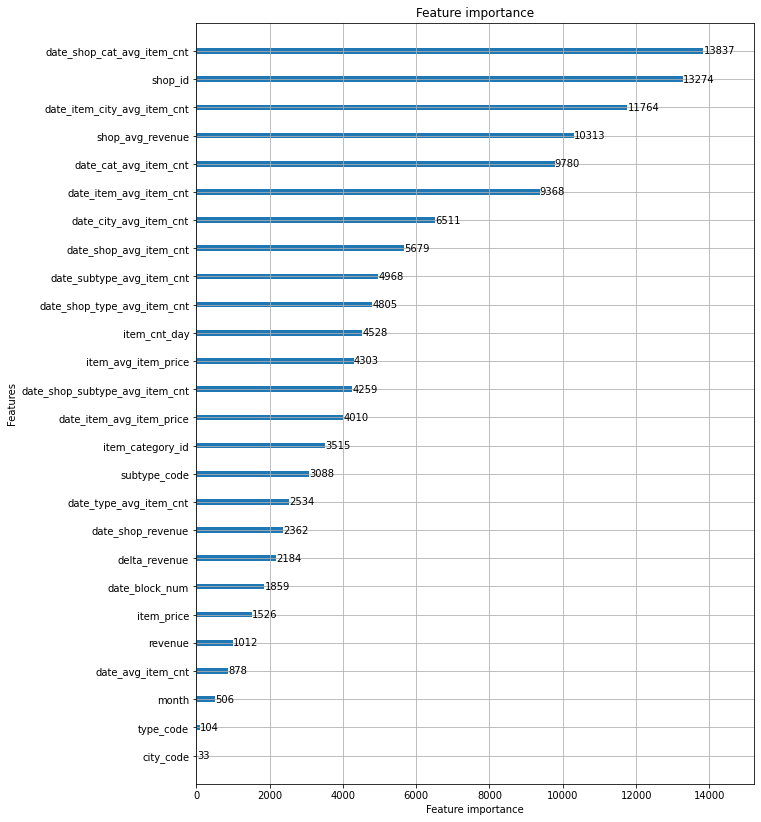

In [9]:
# importance of each feature plotted
fig, ax = plt.subplots(1,1,figsize=(10,14))
lgb.plot_importance(booster=lgb_model, ax=ax)

#### date_shop_cat_avg_item_cnt - Mean no. of items sold per month for each month and shop_id and item_category_id has the highest f-score. While city code has the lowest f-score

In [10]:
# Model saved
filename = "lgb_model.joblib"
joblib.dump(lgb_model, filename)

['lgb_model.joblib']